In [1]:
import time
import pickle
import numpy as np
from scipy import signal
from scipy import fftpack
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import f06_postpro as f06
import dat_tools as dat
import utils
import rfp
import oma
import mac

### Funciones de transferencia nodales por simulación

In [2]:
connect_dict_subassembly_fewer = {
    '1': ['11', '14'],
    '11': ['14', '15'],
    '18': ['14', '15'],
    '23': ['11', '14', '15', '18']
}

connect_dict_filename = 'connect_dict_subassembly_fewer.pickle'
with open(connect_dict_filename, 'wb') as handle:
    pickle.dump(connect_dict_subassembly_fewer, handle)

In [3]:
# Diccionario de conexiones nodales
connect_dict_filename = 'connect_dict_subassembly_fewer.pickle'
with open(connect_dict_filename, 'rb') as handle:
    connect_dict = pickle.load(handle)

In [122]:
f06_sinsweep_filname = 'C:\RUNRUN\sate_subassembly_sinex_fewer.f06'
f06_modal_filname = r'C:\RUNRUN\modal_femap\sate_subassemblies_modalhm-000.f06'
dat_sinsweep_filname = 'C:\RUNRUN\sate_subassembly_sinex_fewer.dat'
freq, accel, nodes = f06.read_nodes_accel(f06_sinsweep_filname)
Xi = dat.read_damping(dat_sinsweep_filname)
coords = dat.read_node_coords(dat_sinsweep_filname, nodes)
mode_freqs_all, modes_theo_all = f06.read_modeshapes(f06_modal_filname, nodes)

In [123]:
# Transfer matrix
input_node = 1
input_node_str = str(input_node)

TF_dict = accel.copy()
# Delete input node
if input_node_str in TF_dict: del TF_dict[input_node_str]

total_nodes = len(TF_dict.keys())
dof_per_node = 3
total_dofs = total_nodes * dof_per_node
TF = np.zeros((len(freq), total_dofs), dtype=complex)
node_order = dict()
node_order['1'] = 0 # nodo origen
dof_order = dict()
col = 0
for node_str in TF_dict.keys():
    dof_order[node_str] = col
    node_order[node_str] = (col+3)//3 # dejo lugar para nodo del origen
    TF[:,col:col+3] = TF_dict[node_str]
    col += 3

In [124]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:total_dofs]

In [125]:
dof_order

{'11': 0, '14': 3, '15': 6, '18': 9, '23': 12}

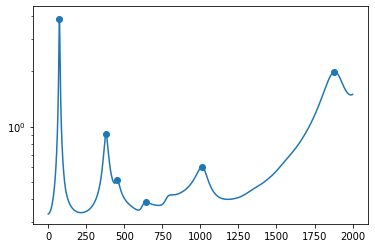

In [126]:
avg_TF = np.mean(np.abs(TF), axis=1)
mode_ind_TF = np.array([m for m in signal.argrelmax(np.abs(avg_TF), order=20)]).flatten()
plt.semilogy(freq, np.abs(avg_TF))
plt.scatter(freq[mode_ind_TF], np.abs(avg_TF[mode_ind_TF]))

In [138]:
freq_analysis_lim = 500

mask = np.unique([np.argmin(np.abs(mode_freqs_all - freq[mode_idx])) for mode_idx in mode_ind_TF])
f_theo = mode_freqs_all[mask]
modes_theo = modes_theo_all[mask,3:].T

total_modes = len(f_theo)
xi_theo = Xi*np.ones(total_modes)
mode_nums = np.arange(total_modes)+1

Max value off diagonal: 0.403


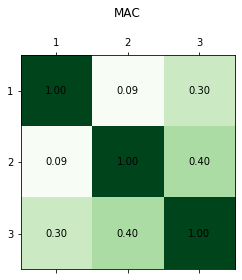

In [140]:
MAC_theo = mac.get_MAC_matrix(modes_theo, modes_theo)
mac.plot_MAC(MAC_theo, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_theo)))

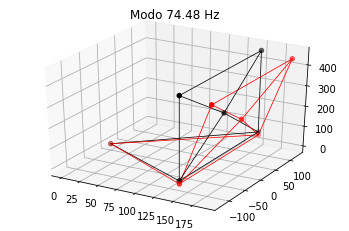

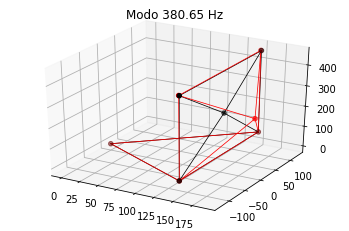

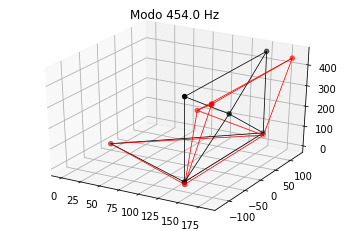

In [141]:
for mode_idx in range(3):
    mode_shape = modes_theo[:, mode_idx]
    mode_name = 'Modo {} Hz'.format(np.round(freq[mode_ind_TF[mode_idx]], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=40)

### Ruido blanco en la base

In [142]:
g_rms = 1
t_end = 60
f_s = 1500
delta_t = 1/f_s
t = np.linspace(0, t_end, int(t_end/delta_t))
Ug_time = g_rms * np.random.normal(size=len(t))

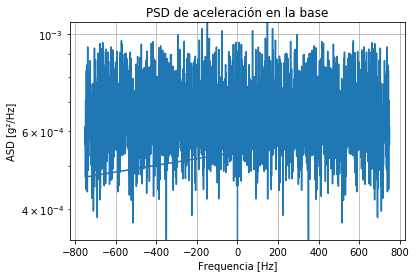

In [143]:
# PSD de aceleraciones en la base
nperseg = 4096
Ug_psd_freq, Ug_psd = signal.welch(Ug_time, 
                      fs=f_s, # sample rate
                      window='hamming', # apply a Hanning window before taking the DFT
                      nperseg=nperseg, # compute periodograms of 256-long segments of x
                      detrend='constant', # detrend x by subtracting the mean)
                      return_onesided=False)

plt.figure()
plt.semilogy(Ug_psd_freq, Ug_psd)
plt.title('PSD de aceleración en la base')
plt.ylim([np.min(Ug_psd[1:]), np.max(Ug_psd[1:])])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('ASD [g²/Hz]')
plt.grid()
plt.show()

In [144]:
# Transformada de Fourier de aceleraciones en la base
Ug_fft = np.fft.fft(Ug_time) * delta_t
Ug_fft_freq = np.fft.fftfreq(len(t), d=delta_t)

In [145]:
# Interpolacion de transferencias las frecuencias de excitación
TF_inter = np.zeros((len(Ug_fft_freq), TF.shape[1]), dtype=complex)
for dof in range(TF.shape[1]):
    TF_inter[:,dof] = np.interp(Ug_fft_freq, freq, TF[:,dof])

In [146]:
# Espectros de respuesta
ddotY_fft = (TF_inter.T*Ug_fft).T

In [147]:
# Respuestas temporales
ddotY_time = fftpack.ifft(ddotY_fft, axis=0)

## GRFP

In [148]:
S_xf = np.zeros((nperseg, total_dofs), dtype=complex)
for dof in range(total_dofs):
        f_Sxf, S_xf[:, dof] = signal.csd(ddotY_time[:, dof], Ug_time,
                                               fs=f_s,
                                               window='hanning',
                                               nperseg=nperseg,
                                               detrend='constant',
                                               axis=0,
                                               return_onesided=False)

In [149]:
f_H = f_Sxf[:len(f_Sxf)//2]
H1 = S_xf[:len(f_H),:]/Ug_psd[:len(f_H), np.newaxis]

In [150]:
DOFS = np.array([8, 9])
freq_range = [0, 500]
idxes = np.where((f_H >= freq_range[0]) & (f_H <=freq_range[1]))[0]

In [151]:
n_modes = 4
m = 2*n_modes-1
n = 2*n_modes
denom, denom_coeff = rfp.grfp_denominator(H1[idxes[:, np.newaxis], DOFS], 2*np.pi*f_H[idxes],n,m)

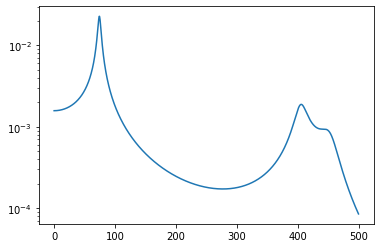

In [152]:
plt.semilogy(f_H[idxes], np.abs(1/denom))

In [153]:
[f_grfp, xi_grfp, modal_mag_n, modal_ang_n], alpha1 = rfp.grfp_parameters(H1[idxes,:], 2*np.pi*f_H[idxes], denom, denom_coeff, m)

In [154]:
print('Frecuencias modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

Frecuencias modales:


Modo,Teoría [Hz],GRFP [Hz]
1,74.48,74.39
2,380.65,405.01
3,454.64,453.46


In [155]:
print('Amortiguamientos modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, xi_theo, xi_grfp]])
data = np.vstack((mode_nums[:min_ind], xi_theo[:min_ind], xi_grfp[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

Amortiguamientos modales:


Modo,Teoría [Hz],GRFP [Hz]
1,0.04,-0.03
2,0.04,0.02
3,0.04,-0.03


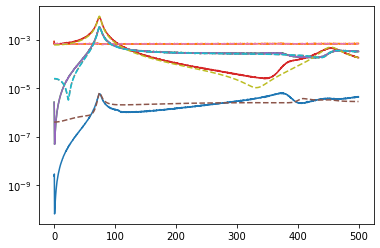

In [156]:
# DOFS = np.array([20,  21])
DOFS = np.array([1, 3, 8, 9, 14])
plt.semilogy(f_H[idxes], np.abs(H1[idxes[:, np.newaxis], DOFS]))
plt.semilogy(f_H[idxes], np.abs(alpha1[:,DOFS]), '--')
plt.show()

Max value off diagonal: 0.938


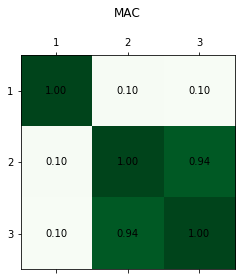

In [157]:
modes_grfp = (modal_mag_n*np.exp(1j*modal_ang_n)).T
MAC_grfp = mac.get_MAC_matrix(modes_grfp, modes_grfp)
mac.plot_MAC(MAC_grfp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_grfp)))

Max value off diagonal: 0.945


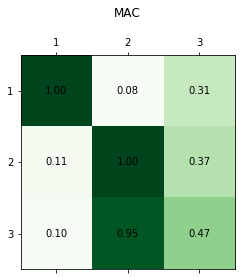

In [158]:
MAC_grfp = mac.get_MAC_matrix(modes_grfp, modes_theo)
mac.plot_MAC(MAC_grfp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_grfp)))

### FDD

In [159]:
S_xx = np.zeros((nperseg, total_dofs, total_dofs), dtype=complex)

start = time.time()
for dof1 in range(total_dofs):
    for dof2 in range(total_dofs):
        f_S, S_xx[:, dof1, dof2] = signal.csd(ddotY_time[:, dof1], ddotY_time[:, dof2],
                                                               fs=f_s,
                                                               window='hanning',
                                                               nperseg=nperseg,
                                                               detrend='constant',
                                                               axis=0,
                                                               return_onesided=False)
end = time.time()
print('Tiempo de calculo de S_xx: {}s'.format(round(end - start,2)))

Tiempo de calculo de S_xx: 4.06s


In [171]:
# Extraigo frecuencias y formas de modo por SVD
u_fdd, s_fdd, vh_fdd = np.linalg.svd(S_xx)

freq_fdd = f_S[:len(f_S)//2]
freq_range = [0, 500]
idxes = np.where(freq_fdd <= freq_range[1])[0]
# Maximos del primer valor singular
mode_ind_fdd = np.array([m for m in signal.argrelmax(s_fdd[idxes, 0], order=300)]).flatten()
mode_ind_fdd2 = np.array([m for m in signal.argrelmax(s_fdd[idxes, 1], order=70)]).flatten()

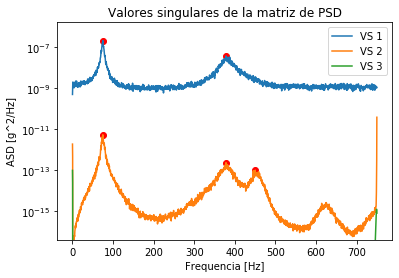

In [172]:
plt.semilogy(freq_fdd, s_fdd[:len(freq_fdd), :3])
plt.ylim([np.min(s_fdd[10:len(freq_fdd), 1]), None])
plt.scatter(freq_fdd[mode_ind_fdd],
            abs(s_fdd[mode_ind_fdd, 0]),
            color='r')
plt.scatter(freq_fdd[mode_ind_fdd2],
            abs(s_fdd[mode_ind_fdd2, 1]),
            color='r')
plt.title('Valores singulares de la matriz de PSD')
plt.ylabel('ASD [g^2/Hz]')
plt.xlabel('Frequencia [Hz]')
lgnd  = ['VS {}'.format(col+1) for col in range(3)]
plt.legend(lgnd, loc='upper right')
plt.show()

In [173]:
f_fdd = freq_fdd[mode_ind_fdd2]
fdd_total_modes = len(f_fdd)
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp, f_fdd]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind], f_fdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'FDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2)

Modo,Teoría [Hz],GRFP [Hz],FDD [Hz]
1,74.48,74.39,75.07
2,380.65,405.01,378.30
3,454.64,453.46,450.07


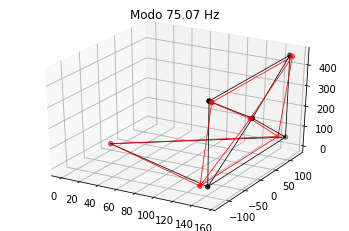

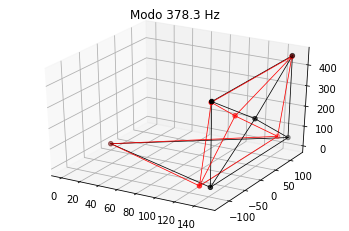

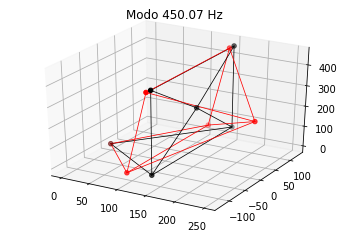

In [174]:
for mode_idx in range(fdd_total_modes):
    mode_shape = u_fdd[mode_ind_fdd2[mode_idx], :, 0]
    mode_name = 'Modo {} Hz'.format(np.round(freq_fdd[mode_ind_fdd2[mode_idx]], 2))
    utils.plot_3d_mode(node_order, coords, connect_dict, mode_shape, mode_name, magnif=100)

Max value off diagonal: 0.533


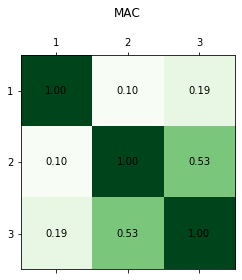

In [175]:
modes_fdd = u_fdd[mode_ind_fdd2[:fdd_total_modes],:,0].T
MAC_fdd = mac.get_MAC_matrix(modes_fdd, modes_fdd)
mac.plot_MAC(MAC_fdd, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_fdd)))

Max value off diagonal: 0.594


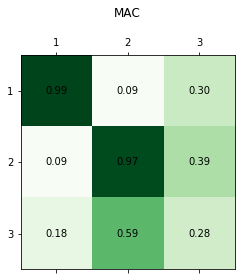

In [176]:
modes_fdd = u_fdd[mode_ind_fdd2[:fdd_total_modes],:,0].T
MAC_fdd = mac.get_MAC_matrix(modes_fdd, modes_theo)
mac.plot_MAC(MAC_fdd, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_fdd)))

In [177]:
mac.get_MAC(u_fdd[mode_ind_fdd2[2],:,1].T, modes_theo[:,2])

0.6923960986473562

In [178]:
mac.get_MAC(u_fdd[mode_ind_fdd2[2],:,1].T, u_fdd[mode_ind_fdd2[1],:,1].T)

0.24566596976927269

### EFDD

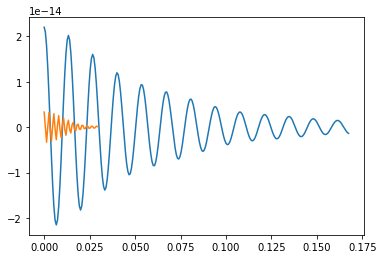

In [180]:
sv_num = 1
mac_th = 0.85
sdof_psd = np.zeros((f_S.size, fdd_total_modes), dtype=complex)
sdof_acf = np.zeros((f_S.size, fdd_total_modes), dtype=complex)
t_sdof_acf = np.linspace(0, sdof_psd.shape[0]*delta_t, sdof_psd.shape[0])
f_efdd = np.zeros(fdd_total_modes)
xi_efdd = np.zeros(fdd_total_modes)
R2 = np.zeros(fdd_total_modes)
for mode in range(fdd_total_modes-1):
    peak_idx = mode_ind_fdd2[mode]
    idx_low, idx_high = oma.get_efdd_segment(u_fdd, peak_idx, mac_th, sv_num)
    sdof_psd[idx_low:idx_high, mode] = s_fdd[idx_low:idx_high, 1]
    sdof_acf[:, mode] = fftpack.ifft(sdof_psd[:, mode])
    # Find index where amplitude stops falling
    decay_end = np.where(np.diff(np.abs(sdof_acf[:, mode]))>0)[0][0] 
    decay = np.real(sdof_acf[:decay_end, mode])
    plt.plot(t_sdof_acf[:decay_end], decay)
    xi_efdd[mode], R2[mode], A, b, c, m = oma.get_damp_from_decay(decay)
    f_efdd_damped = oma.get_freq_from_signal(t_sdof_acf, sdof_acf[:, mode])
    f_efdd[mode] = f_efdd_damped / np.sqrt(1-xi_efdd[mode]**2)
    peak_nums = np.linspace(1, A.shape[0], A.shape[0])

### CFDD

[ 1.68854259e-20  2.17375079e-11 -9.30603721e-06]
[ 5.09755486e-24  3.08811895e-14 -3.50476272e-07]


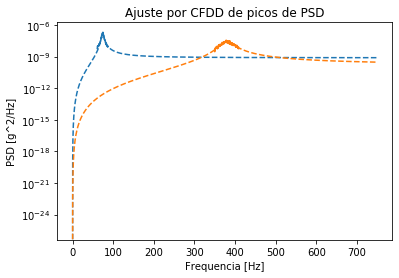

In [181]:
sv_num = 0
mac_th = 0.9
f_cfdd = np.zeros(fdd_total_modes)
xi_cfdd = np.zeros(fdd_total_modes)

freq_hat = np.linspace(0, f_S[len(f_S)//2-1], len(f_S)*4)
psd_hat = np.zeros((freq_hat.size, fdd_total_modes))

for mode in range(fdd_total_modes-1):
    peak_idx = mode_ind_fdd[mode]
    efdd_idxes = oma.get_efdd_segment(u_fdd, peak_idx, mac_th, sv_num)
    f_cfdd[mode], xi_cfdd[mode], psd_hat[:, mode] = oma.curve_fit_psd_peak(f_S[:len(f_S)//2], s_fdd[:len(f_S)//2, 0], efdd_idxes, freq_hat)
    
    plt.semilogy(f_S[efdd_idxes[0]:efdd_idxes[1]],
                 abs(s_fdd[efdd_idxes[0]:efdd_idxes[1], 0]),
                 color=colors[mode])
    plt.semilogy(freq_hat[:freq_hat.size],
                 abs(psd_hat[:freq_hat.size, mode]),
                 color=colors[mode],
                 linestyle='--')

plt.title('Ajuste por CFDD de picos de PSD')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('PSD [g^2/Hz]')
plt.show()

In [182]:
f_S[:len(f_S)//2].shape

(2048,)

In [183]:
papa = s_fdd[idxes, 0]
bink = papa[efdd_idxes[0]:efdd_idxes[1]]
bink.shape

(163,)

In [184]:
print('Frecuencias modales:')
min_ind = np.min([len(vec) for vec in [mode_nums, f_theo, f_grfp, f_fdd, f_efdd, f_cfdd]])
data = np.vstack((mode_nums[:min_ind], f_theo[:min_ind], f_grfp[:min_ind], f_fdd[:min_ind], f_efdd[:min_ind], f_cfdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'FDD [Hz]', 'EFDD [Hz]', 'CFDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=2, save_title='tab_compare_freq_lessTime')

Frecuencias modales:


Modo,Teoría [Hz],GRFP [Hz],FDD [Hz],EFDD [Hz],CFDD [Hz]
1,74.48,74.39,75.07,74.31,73.71
2,380.65,405.01,378.30,378.56,379.66
3,454.64,453.46,450.07,0.00,0.00


In [185]:
min_ind = np.min([len(vec) for vec in [mode_nums, xi_theo, xi_grfp, xi_efdd, xi_cfdd]])
data = np.vstack((mode_nums[:min_ind], xi_theo[:min_ind], xi_grfp[:min_ind], xi_efdd[:min_ind], xi_cfdd[:min_ind])).T
headers = ['Modo', 'Teoría [Hz]', 'GRFP [Hz]', 'EFDD [Hz]', 'CFDD [Hz]']
utils.print_modes_dataframe(data=data, headers=headers, decimals=3, save_title='tab_compare_damp_lessTime')

Modo,Teoría [Hz],GRFP [Hz],EFDD [Hz],CFDD [Hz]
1,0.040,-0.033,0.038,0.032
2,0.040,0.024,0.054,0.037
3,0.040,-0.031,0.000,0.000
